In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings("ignore")

We build a volatility model for the EUR/USD exchange rate returns in three steps: </br>
• Specify **Gaussian AR(p) model** for the returns </br>
The model residuals are **heavy-tailed**, relative to the Gaussian distribution and exhibit **non-linear dependence**, i.e., autocorrelations in the squared residuals series.</br>
• Specify **Gaussian AR(p) + GARCH(1,1) model** for the returns</br>
This model accommodates the non-linear dependence and reduces the severity of the heavy-tailed distribution of the residuals, relative to a Gaussian distribution.</br>
• Specify **t-Distribution AR(p) + GARCH(1,1) model** for the returns </br>
This model explicitly incorporates non-linear dependence in the residuals (i.e., volatility) and provides a specific distribution alternative to the Gaussian with excess kurtosis (i.e., heavier tails).

<h3> Load Dataset </h3>

The Federal Reserve Economic Database (FRED) provides historical daily exchange rates of all major currencies in the world.

In [2]:
df = pd.read_csv('datasets/fred_fxrates.csv')
mask = (df['Date'] >= '1999-01-04') & (df['Date'] <= '2013-09-27')
df = df.loc[mask]
df = df.set_index('Date')
df.index = pd.to_datetime(df.index)
fxrates = df[["DEXCHUS", "DEXJPUS", "DEXKOUS", "DEXMAUS", "DEXUSEU", "DEXUSUK", "DEXTHUS", "DEXSZUS"]]

print(fxrates.shape)

(3709, 8)


In [3]:
fxrates.head() 

,DEXCHUS,DEXJPUS,DEXKOUS,DEXMAUS,DEXUSEU,DEXUSUK,DEXTHUS,DEXSZUS
Date,,,,,,,,
1999-01-04,8.2793,112.15,1187.5,3.8,1.1812,1.6581,36.20,1.3666
1999-01-05,8.2795,111.15,1166.0,3.8,1.1760,1.6566,36.18,1.3694
1999-01-06,8.2795,112.78,1160.0,3.8,1.1636,1.6547,36.50,1.3852
1999-01-07,8.2798,111.69,1151.0,3.8,1.1672,1.6495,36.30,1.3863
1999-01-08,8.2796,111.52,1174.0,3.8,1.1554,1.6405,36.45,1.3970


In [4]:
fxrates.tail() 

,DEXCHUS,DEXJPUS,DEXKOUS,DEXMAUS,DEXUSEU,DEXUSUK,DEXTHUS,DEXSZUS
Date,,,,,,,,
2013-09-23,6.1201,98.76,1073.90,3.1990,1.3520,1.6066,31.18,0.9100
2013-09-24,6.1208,98.76,1074.35,3.2150,1.3490,1.6006,31.27,0.9114
2013-09-25,6.1190,98.62,1076.42,3.2210,1.3536,1.6080,31.22,0.9082
2013-09-26,6.1194,98.95,1075.20,3.2145,1.3484,1.6012,31.16,0.9105
2013-09-27,6.1179,98.30,1074.38,3.2260,1.3537,1.6135,31.28,0.9050


<h3> Symbols & Its Units Details </h3>

In [5]:
symbols = ["DEXCHUS", "DEXJPUS", "DEXKOUS", "DEXMAUS", "DEXUSEU", "DEXUSUK", "DEXTHUS", "DEXSZUS"]
fxUnits = ["Chinese Yuan to 1 U.S. $", "Japanese Yen to 1 U.S. $", "South Korean Won to 1 U.S. $", 
           "Malaysian Ringgit to 1 U.S. $", "U.S. $ to 1 Euro", "U.S. $ to 1 British Pound", 
           "Thai Baht to 1 U.S. $", "Swiss Francs to 1 U.S. $"] 
df = pd.DataFrame(columns=["Symbols","fxUnits"])
df["Symbols"] = symbols
df["fxUnits"] = fxUnits
display(df)

,Symbols,fxUnits
0,DEXCHUS,Chinese Yuan to 1 U.S. $
1,DEXJPUS,Japanese Yen to 1 U.S. $
2,DEXKOUS,South Korean Won to 1 U.S. $
3,DEXMAUS,Malaysian Ringgit to 1 U.S. $
4,DEXUSEU,U.S. $ to 1 Euro
5,DEXUSUK,U.S. $ to 1 British Pound
6,DEXTHUS,Thai Baht to 1 U.S. $
7,DEXSZUS,Swiss Francs to 1 U.S. $


<h3> DEXUSEU Log Returns </h3>

In [6]:
fx_USEU_log_returns = np.log(fxrates['DEXUSEU'] / fxrates['DEXUSEU'].shift(1)).dropna()
print(fx_USEU_log_returns.head())

Date
1999-01-05   -0.004412
1999-01-06   -0.010600
1999-01-07    0.003089
1999-01-08   -0.010161
1999-01-11   -0.001733
Name: DEXUSEU, dtype: float64


<h3> Plot DEXUSEU Exchange Rates & Returns </h3>

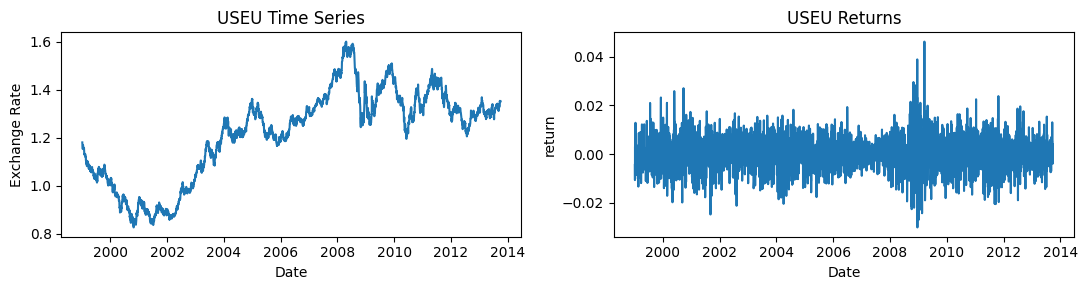

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(11, 3))

# Plot 'USEU' 
axes[0].plot(fxrates['DEXUSEU'])
axes[0].set_title('USEU Time Series')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Exchange Rate')

# Plot 'USEU' returns
axes[1].plot(fx_USEU_log_returns)
axes[1].set_title('USEU Returns')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('return')

plt.tight_layout()
plt.show() 

<h3> Plot ACF & PACF </h3>

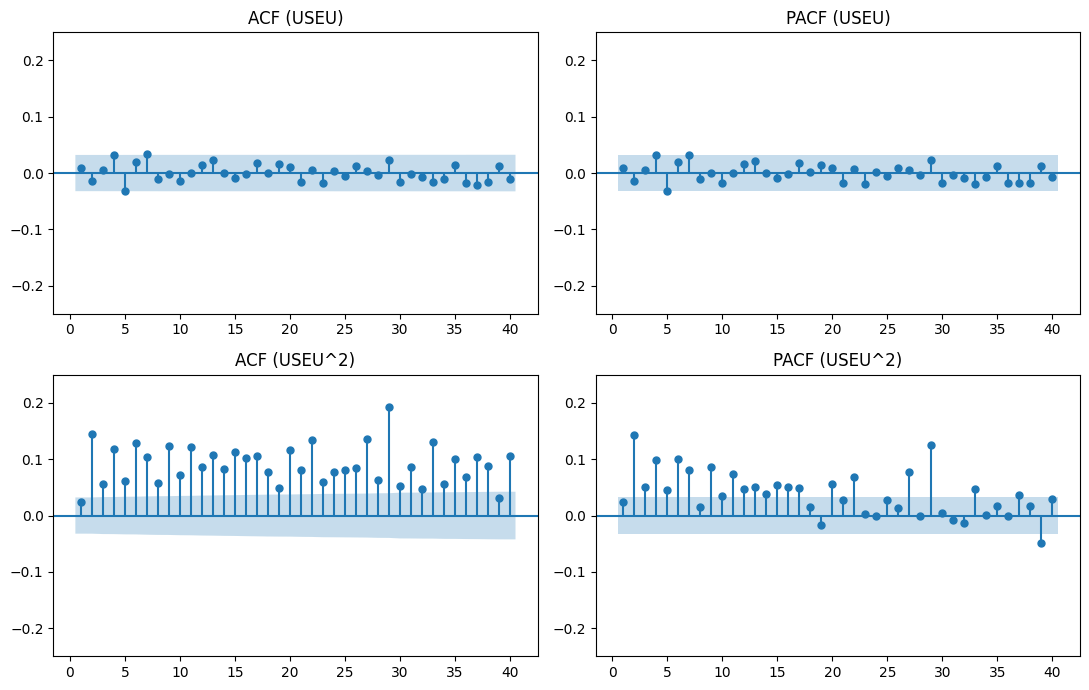

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(11, 7))

# Plot ACF of 'USEU'
plot_acf(fx_USEU_log_returns, lags=40, ax=axes[0,0], zero=False, title="ACF (USEU)")
axes[0,0].set_ylim(-0.25, 0.25)

# Plot PACF of 'USEU'
plot_pacf(fx_USEU_log_returns, lags=40, ax=axes[0,1],zero=False, title="PACF (USEU)")
axes[0,1].set_ylim(-0.25, 0.25)

# Plot ACF of 'USEU^2'
plot_acf(fx_USEU_log_returns**2, lags=40, ax=axes[1,0],zero=False, title="ACF (USEU^2)")
axes[1,0].set_ylim(-0.25, 0.25)

# Plot PACF of 'USEU^2'
plot_pacf(fx_USEU_log_returns**2, lags=40, ax=axes[1,1],zero=False, title="PACF (USEU^2)")
axes[1,1].set_ylim(-0.25, 0.25)

plt.tight_layout()
plt.show() 

Marginally significant time dependence is present in the returns, while highly significant time dependence is apparent in the squared returns.

<h3> Augmented Dickey-Fuller Test For Stationarity / Non-Stationarity </h3>

In [9]:
# Function to perform Augmented Dickey-Fuller Test and print the results
def perform_adf_test(series):
    result = sm.tsa.adfuller(series, autolag='AIC')
    print(f"Results:")
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"\t{key}: {value}")
    print("\n")
    
# Perform the Augmented Dickey-Fuller Test for un-differenced series
perform_adf_test(fx_USEU_log_returns)

Results:
ADF Statistic: -21.94115355554684
p-value: 0.0
Critical Values:
	1%: -3.4321181278924793
	5%: -2.86232126099387
	10%: -2.567185876515552




<h3> Find Best AR(p) Model </h3>

The best AR(p) order is: 7
The AIC value of the best AR model is: -26869.6557972992


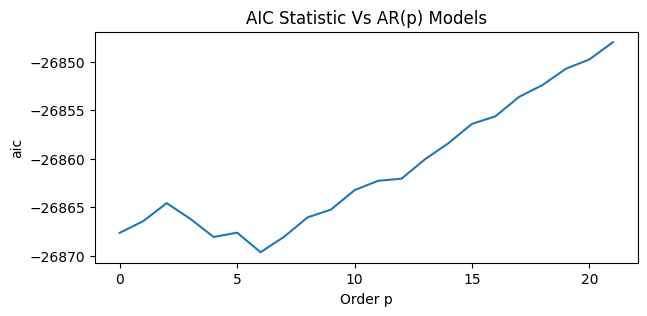

In [10]:
# Fit ARIMA(p,0,0) models with different AR orders (p) and select the best based on AIC
aic = []
best_aic = float("inf")
best_order = None

max_lag = 22

for p in range(1, max_lag+1):
    model = ARIMA(fx_USEU_log_returns, order=(p,0,0))  # AR(p) model with zero differences (d=0) and zero moving average (q=0)
    result = model.fit()
    aic.append(result.aic)
    if result.aic < best_aic:
        best_aic = result.aic
        best_order = p

print(f"The best AR(p) order is: {best_order}")
print(f"The AIC value of the best AR model is: {best_aic}")

# Plot aic vs order p
plt.figure(figsize=(7, 3))
plt.plot(aic)
plt.xlabel('Order p')
plt.ylabel('aic')
plt.title('AIC Statistic Vs AR(p) Models')
plt.show()

<h3> Fit AR(7) Model </h3>

In [11]:
# Create lagged versions of fx_USEU_log_returns
fx_USEU_log_returns_lag1 = fx_USEU_log_returns.shift(1)
fx_USEU_log_returns_lag2 = fx_USEU_log_returns.shift(2)
fx_USEU_log_returns_lag3 = fx_USEU_log_returns.shift(3)
fx_USEU_log_returns_lag4 = fx_USEU_log_returns.shift(4)
fx_USEU_log_returns_lag5 = fx_USEU_log_returns.shift(5)
fx_USEU_log_returns_lag6 = fx_USEU_log_returns.shift(6)
fx_USEU_log_returns_lag7 = fx_USEU_log_returns.shift(7)

# Concatenate the lagged versions into a DataFrame for regression
data = pd.concat([fx_USEU_log_returns, fx_USEU_log_returns_lag1, fx_USEU_log_returns_lag2, fx_USEU_log_returns_lag3, fx_USEU_log_returns_lag4, fx_USEU_log_returns_lag5, fx_USEU_log_returns_lag6, fx_USEU_log_returns_lag7], axis=1)
data.columns = ['fx_USEU_log_returns', 'fx_USEU_log_returns.lag1', 'fx_USEU_log_returns.lag2', 'fx_USEU_log_returns.lag3', 'fx_USEU_log_returns.lag4', 'fx_USEU_log_returns.lag5', 'fx_USEU_log_returns.lag6', 'fx_USEU_log_returns.lag7']

# Drop any rows with missing values after creating the lagged variables
data.dropna(inplace=True)

# Fit the AR(7) model using OLS regression
y = data['fx_USEU_log_returns']
X = data[['fx_USEU_log_returns.lag1', 'fx_USEU_log_returns.lag2', 'fx_USEU_log_returns.lag3', 'fx_USEU_log_returns.lag4', 'fx_USEU_log_returns.lag5', 'fx_USEU_log_returns.lag6', 'fx_USEU_log_returns.lag7']]

X = sm.add_constant(X)  # Add constant term to the model

model = sm.OLS(y,X).fit()

# Print the summary statistics of the fitted model
print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     fx_USEU_log_returns   R-squared:                       0.004
Model:                             OLS   Adj. R-squared:                  0.002
Method:                  Least Squares   F-statistic:                     2.019
Date:                 Tue, 16 Jan 2024   Prob (F-statistic):             0.0492
Time:                         00:15:29   Log-Likelihood:                 13420.
No. Observations:                 3701   AIC:                        -2.682e+04
Df Residuals:                     3693   BIC:                        -2.677e+04
Df Model:                            7                                         
Covariance Type:             nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const         

<h3> AR(7) Model Diagnostics </h3>

In [12]:
# Obtain standardized residuals
ar7_residuals = model.resid
ar7_standardized_residuals = ar7_residuals / np.std(ar7_residuals)

<h4> Plot ACF / PACF </h4>

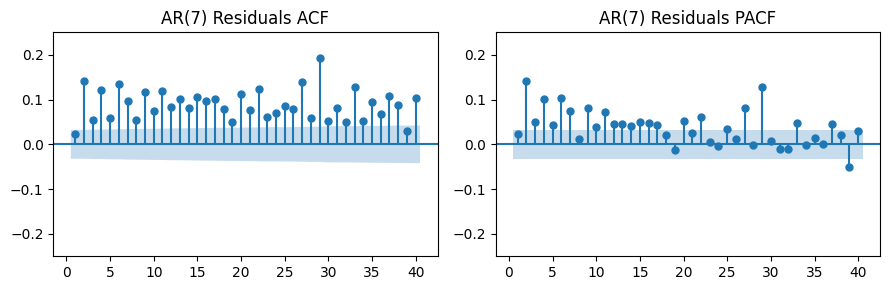

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3))

# Plot ACF of 'ar7_residuals^2'
plot_acf(ar7_residuals**2, lags=40, ax=axes[0], zero=False, title="AR(7) Residuals ACF")
axes[0].set_ylim(-0.25, 0.25)

# Plot PACF of 'ar7_residuals^2'
plot_pacf(ar7_residuals**2, lags=40, ax=axes[1],zero=False, title="AR(7) Residuals PACF")
axes[1].set_ylim(-0.25, 0.25)

plt.tight_layout()
plt.show() 

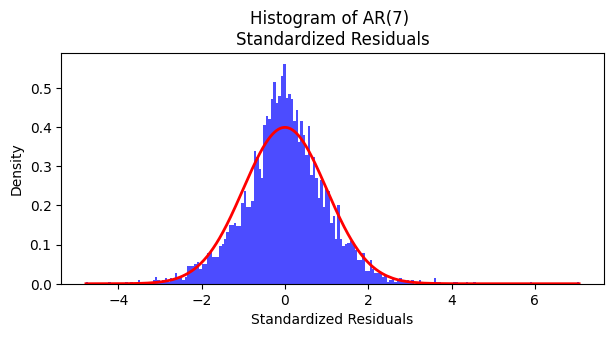

In [14]:
# Plot Histogram of Standardized Residuals
plt.figure(figsize=(7, 3))
hist0 = plt.hist(ar7_standardized_residuals, bins=200, density=True, color='blue', alpha=0.7)
x_density = np.sort(ar7_standardized_residuals)
y_density = stats.norm.pdf(x_density)
plt.plot(x_density, y_density, color='red', linewidth=2)
plt.title("Histogram of AR(7) \nStandardized Residuals")
plt.xlabel("Standardized Residuals")
plt.ylabel("Density")
plt.show()

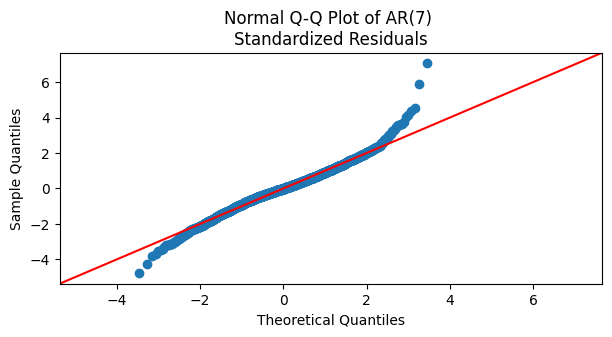

In [15]:
# Normal Q-Q Plot of Standardized Residuals
fig = sm.qqplot(ar7_standardized_residuals, line='45', color='skyblue')
plt.title("Normal Q-Q Plot of AR(7) \nStandardized Residuals")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
fig.set_size_inches(7,3)
plt.show()

<h3> Fit AR(7) + GARCH(1,1) Model </h3>

In [16]:
# Fit the AR(7) + GARCH(1,1) model

'''
The rescale=True is used when the model fails to converge to a result. So rescale could be a solution for the problem. 
If the model doesn't need rescale, even if the parameter is True, it will not do anything.
If the rescale=True and, in fact, rescaled the series. It's necessary to adjust the outputs. 
The correct thing to do is to set the parameter as True and get the rescale value after that.
Divide Conditional volatility by scale
'''
garch11_model = arch_model(fx_USEU_log_returns, mean='AR', lags=7, vol='Garch', p=1, q=1, rescale=True).fit(disp='off')
print(garch11_model.summary())
print(garch11_model.scale)

                           AR - GARCH Model Results                           
Dep. Variable:                DEXUSEU   R-squared:                       0.003
Mean Model:                        AR   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -3438.92
Distribution:                  Normal   AIC:                           6899.85
Method:            Maximum Likelihood   BIC:                           6968.23
                                        No. Observations:                 3701
Date:                Tue, Jan 16 2024   Df Residuals:                     3693
Time:                        00:15:29   Df Model:                            8
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
Const           0.0131  9.851e-03      1.335      0.

<h3> AR(7) + GARCH(1,1) Model Diagnostics </h3>

In [17]:
garch11_standardized_residuals = (garch11_model.resid / garch11_model.conditional_volatility)

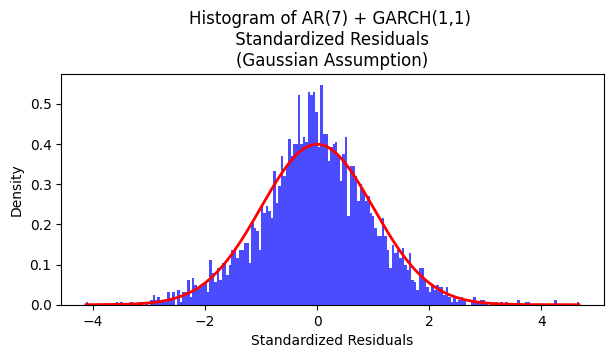

In [18]:
# Plot Histogram of Standardized Residuals
plt.figure(figsize=(7, 3))
hist0 = plt.hist(garch11_standardized_residuals, bins=200, density=True, color='blue', alpha=0.7)
x_density = np.sort(garch11_standardized_residuals)
y_density = stats.norm.pdf(x_density)
plt.plot(x_density, y_density, color='red', linewidth=2)
plt.title("Histogram of AR(7) + GARCH(1,1) \n Standardized Residuals \n(Gaussian Assumption)")
plt.xlabel("Standardized Residuals")
plt.ylabel("Density")
plt.show()

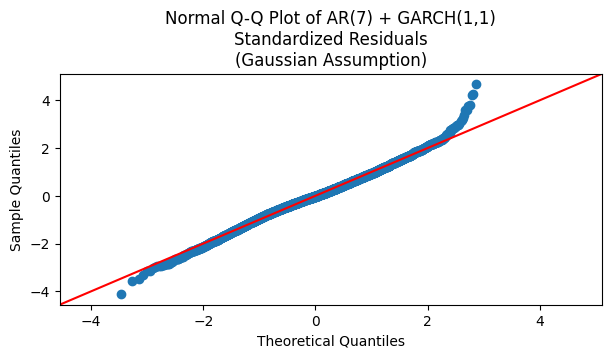

In [19]:
# Normal Q-Q Plot of Standardized Residuals
fig = sm.qqplot(garch11_standardized_residuals, line='45', color='skyblue')
plt.title("Normal Q-Q Plot of AR(7) + GARCH(1,1)\nStandardized Residuals\n(Gaussian Assumption)")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
fig.set_size_inches(7,3)
plt.show()

These results show how the AR(7) + GARCH(1,1) model with Gaussian residuals improves the fit in terms of the QQ plot when compared to the AR(7) model with no GARCH structure

<h3> Fit AR(7) + GARCH(1,1) t-Distribution Model </h3>

In [20]:
# Fit the AR(7) + GARCH(1,1) t-Distribution model
garch11_tdis_model = arch_model(fx_USEU_log_returns, mean='AR', lags=7, vol='Garch', p=1, q=1, rescale=True, dist="StudentsT").fit(disp='off')
print(garch11_tdis_model.summary())

                              AR - GARCH Model Results                              
Dep. Variable:                      DEXUSEU   R-squared:                       0.002
Mean Model:                              AR   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -3412.41
Distribution:      Standardized Student's t   AIC:                           6848.82
Method:                  Maximum Likelihood   BIC:                           6923.42
                                              No. Observations:                 3701
Date:                      Tue, Jan 16 2024   Df Residuals:                     3693
Time:                              00:15:30   Df Model:                            8
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------

<h3> AR(7) + GARCH(1,1) t-Distribution Model Diagnostics </h3>

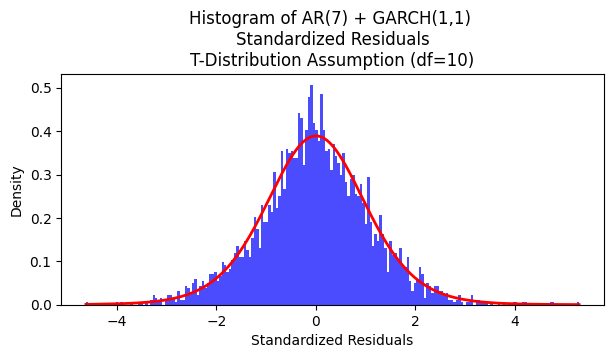

In [21]:
# Calculate the standardized residuals
df0 = 10 # Estimated by Model using MLE (see nu parameter in summary above)
garch11_tdis_standardized_residuals = (garch11_tdis_model.resid / garch11_tdis_model.conditional_volatility) * np.sqrt(df0 / (df0 - 2))

plt.figure(figsize=(7, 3))
hist0 = plt.hist(garch11_tdis_standardized_residuals, bins=200, density=True, color='blue', alpha=0.7)
x_density = np.sort(garch11_tdis_standardized_residuals)
y_density = stats.t.pdf(x_density, df=df0)
plt.plot(x_density, y_density, color='red', linewidth=2)
plt.title("Histogram of AR(7) + GARCH(1,1) \nStandardized Residuals\nT-Distribution Assumption (df=10)")
plt.xlabel("Standardized Residuals")
plt.ylabel("Density")
plt.show()

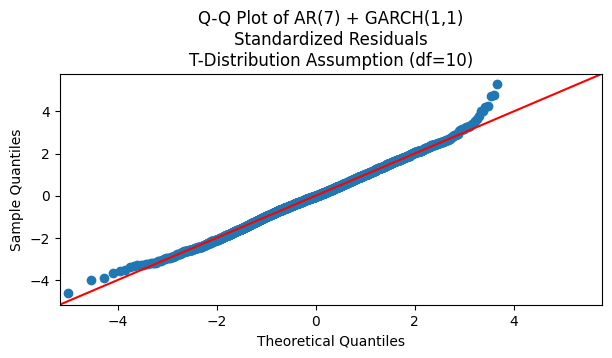

In [22]:
# Normal Q-Q Plot of Standardized Residuals
fig = sm.qqplot(garch11_tdis_standardized_residuals, stats.t, distargs=(10,), line='45', color='skyblue')
plt.title("Q-Q Plot of AR(7) + GARCH(1,1)\nStandardized Residuals\nT-Distribution Assumption (df=10)")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
fig.set_size_inches(7,3)
plt.show()

These results show that adjusting the AR(7) + GARCH(1,1) model to assume t-distribution(df=8) for the residuals improves the fit.

<h3> Plot Fitted Daily Volatilities </h3>

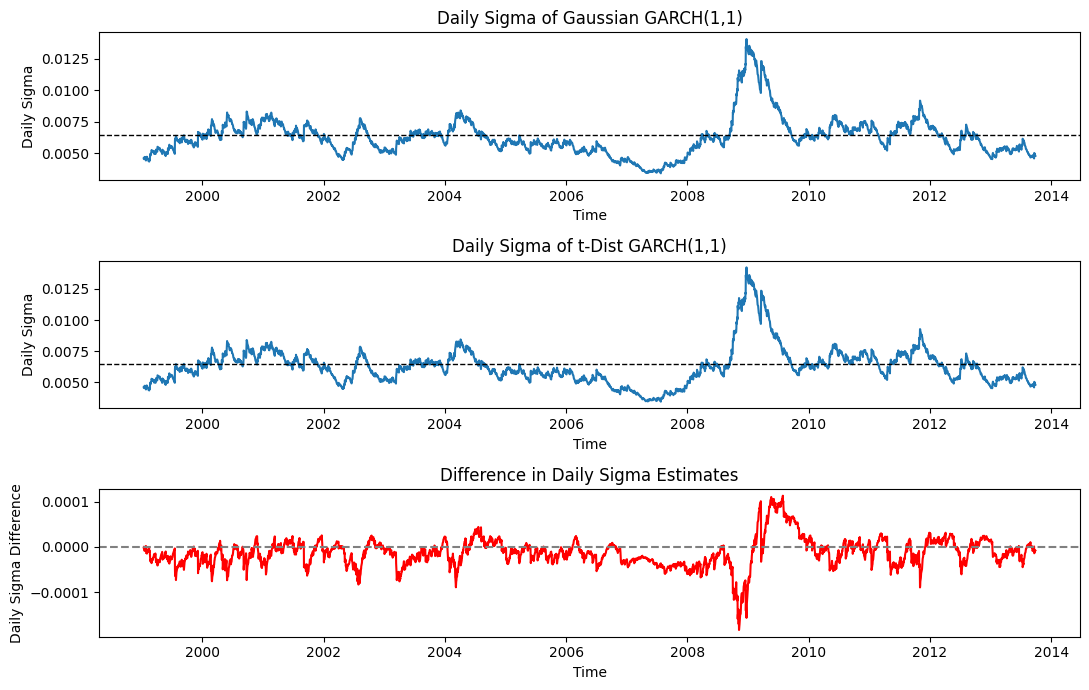

In [23]:
# Calculate the sample variance of the original data 'fx_USEU_log_returns'
sample_variance = np.var(fx_USEU_log_returns)

fig, axes = plt.subplots(3, 1, figsize=(11, 7))

# Plot Daily Sigma of Gaussian GARCH(1,1)
axes[0].plot(garch11_model.conditional_volatility/garch11_model.scale)
axes[0].axhline(y=np.sqrt(sample_variance), color='black', linestyle='dashed', linewidth=1)
axes[0].set_title("Daily Sigma of Gaussian GARCH(1,1)")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Daily Sigma")


# Plot Daily Sigma of t-Distribution GARCH(1,1)
axes[1].plot(garch11_tdis_model.conditional_volatility/garch11_tdis_model.scale)
axes[1].axhline(y=np.sqrt(sample_variance), color='black', linestyle='dashed', linewidth=1)
axes[1].set_title("Daily Sigma of t-Dist GARCH(1,1)")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Daily Sigma")

# Plot Difference in Daily Sigma Estimates
axes[2].plot((garch11_model.conditional_volatility/garch11_model.scale) - (garch11_tdis_model.conditional_volatility/garch11_tdis_model.scale), color='red')
axes[2].axhline(0, color="grey", linestyle="--")
axes[2].set_title("Difference in Daily Sigma Estimates")
axes[2].set_xlabel("Time")
axes[2].set_ylabel("Daily Sigma Difference")

plt.tight_layout()
plt.show()

<h3> Plot Fitted Annualized Volatilities / (Volatilities) </h3>

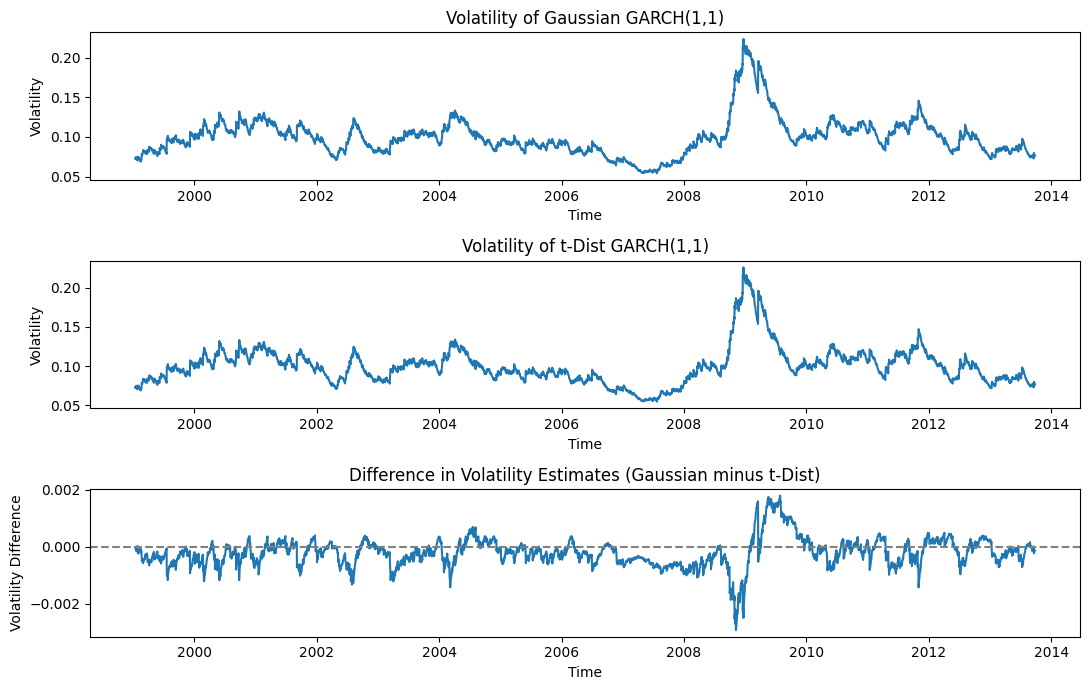

In [24]:
# Calculate annualized volatility
annualized_volatility_garch = np.sqrt(252) * (garch11_model.conditional_volatility/garch11_model.scale)
annualized_volatility_garch_tdis = np.sqrt(252) * (garch11_tdis_model.conditional_volatility/garch11_tdis_model.scale)

fig, axes = plt.subplots(3, 1, figsize=(11, 7))

# Plot Annualized Volatility of Gaussian GARCH(1,1)
axes[0].plot(annualized_volatility_garch, label="Gaussian GARCH(1,1)")
axes[0].set_title("Volatility of Gaussian GARCH(1,1)")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Volatility")

# Plot Annualized Volatility of t-Distribution GARCH(1,1)
axes[1].plot(annualized_volatility_garch_tdis, label="t-Dist GARCH(1,1)")
axes[1].set_title("Volatility of t-Dist GARCH(1,1)")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Volatility")

# Plot Difference in Annualized Volatility Estimates
axes[2].plot(annualized_volatility_garch - annualized_volatility_garch_tdis, label="Difference")
axes[2].axhline(0, color="grey", linestyle="--")
axes[2].set_title("Difference in Volatility Estimates (Gaussian minus t-Dist)")
axes[2].set_xlabel("Time")
axes[2].set_ylabel("Volatility Difference")

plt.tight_layout()
plt.show()